In [22]:
%load_ext autoreload
%autoreload 2
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import particle as pt
from anytree import Node, RenderTree


import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('/home/henrique/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/personal/Henrique/')
from ana_tree_class import AnaTreeAnalyzer

plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_theta_phi(dcosx, dcosy, dcosz):
    """ Return theta and phi from versors
    I am keeping the geant output of theta[0, pi] and phi[-pi,pi]
    """
    theta = np.arccos(dcosz)
    if dcosx == 0:
        phi = 0
        if dcosy == 0:
            pass
        elif dcosy > 0:
            phi = np.pi/2
        elif dcosy < 0:
            phi = -np.pi/2
        return theta, phi

    phi = np.arctan(dcosy/dcosx)
    if phi == 0:
        if (dcosx > 0):
            return theta, phi
        else:
            return theta, phi+np.pi
    if phi > 0:
        if dcosx > 0:
            return theta, phi
        else:
            return theta, phi-np.pi
    else: 
        if dcosx > 0:
            return theta, phi
        else:
            return theta, np.pi+phi

In [23]:
file = uproot.open("./ana_tree_5k.root:analysistree")
tree = file["anatree"]
data = tree.arrays(entry_stop=99999) 
file.close()

In [55]:

mask = data["nuPDG_truth"][:,0]
mask = np.isin(mask, [14,-14])
mask2 = data["ntracks_pandoraTrack"] > 0

mask_scat = data["pdg_geant"][:,0]
mask_scat  = np.isin(mask_scat, [14,-14])

data_nu = data[mask]

data_nu_and_track = data[mask & mask2 & ~mask_scat]
ana = AnaTreeAnalyzer(data_nu_and_track)
mu_ke = []
mu_p = []
mu_ke_from_p = []
mu_true_ke = []
for ana.ev in data_nu_and_track:
    # print(f'event: {ana.ev["event"]}')
    ana.make_tree()
    ana.create_pdg_ids()
    # ana.print_pdg_tree(2,node=0, En="Eng_geant", P="P_geant", InTPC="inTPCActive_geant",EndE="EndE_geant",Ed="StartE_tpcAV_geant", Edf="EndE_tpcAV_geant")
    for i in range(ana.ev["ntracks_pandoraTrack"]):
        track_to_pdg_id = ana.ev["trkidtruth_pandoraTrack"][i]
        track_to_pdg_id = list(set(track_to_pdg_id[track_to_pdg_id != -1]))
        # if len(track_to_pdg_id) > 1:
        #     print("~"*30)
        #     print(f"STOO{'O'*20}P")
        #     for id in track_to_pdg_id:
        #         print(f'{id}, pdg = {ana.get_pdg_name(ana.pdgs[id][0])}')
        #     print("~"*30)
        track_to_pdg_id = track_to_pdg_id[0]
        pdg_idx = ana.pdgs[track_to_pdg_id][1]
        pdg_code = ana.ev["pdg_geant"][pdg_idx]
        if abs(pdg_code) != 13:
            continue
        pdg_mass = pt.Particle.from_pdgid(pdg_code).mass

        track_ke = ana.ev["trkke_pandoraTrack"][i]
        track_ke = track_ke[track_ke > 0]
        track_ke = track_ke[track_ke < 1e5]
        if len(track_ke)<1:
            continue
        track_ke = sum(track_ke)/len(track_ke)
        # track_ke = np.sqrt(track_ke*(track_ke+2*pdg_mass))
        track_mom = ana.ev["trkmomrange_pandoraTrack"][i]
        track_ke_from_range = np.sqrt(track_mom**2 + (pdg_mass/1000)**2) - pdg_mass/1000
        mu_ke.append(track_ke)
        mu_p.append(track_mom)
        mu_ke_from_p.append(track_ke_from_range)
        mu_true_ke.append(ana.ev["StartE_drifted_geant"][pdg_idx] - ana.ev["EndE_drifted_geant"][pdg_idx])

        # print(f'{ana.get_pdg_name(ana.ev["pdg_geant"][pdg_idx])}, id:{track_to_pdg_id} En = {track_ke}, P = {track_mom}, K_range = {track_ke_from_range}')

    # print("")


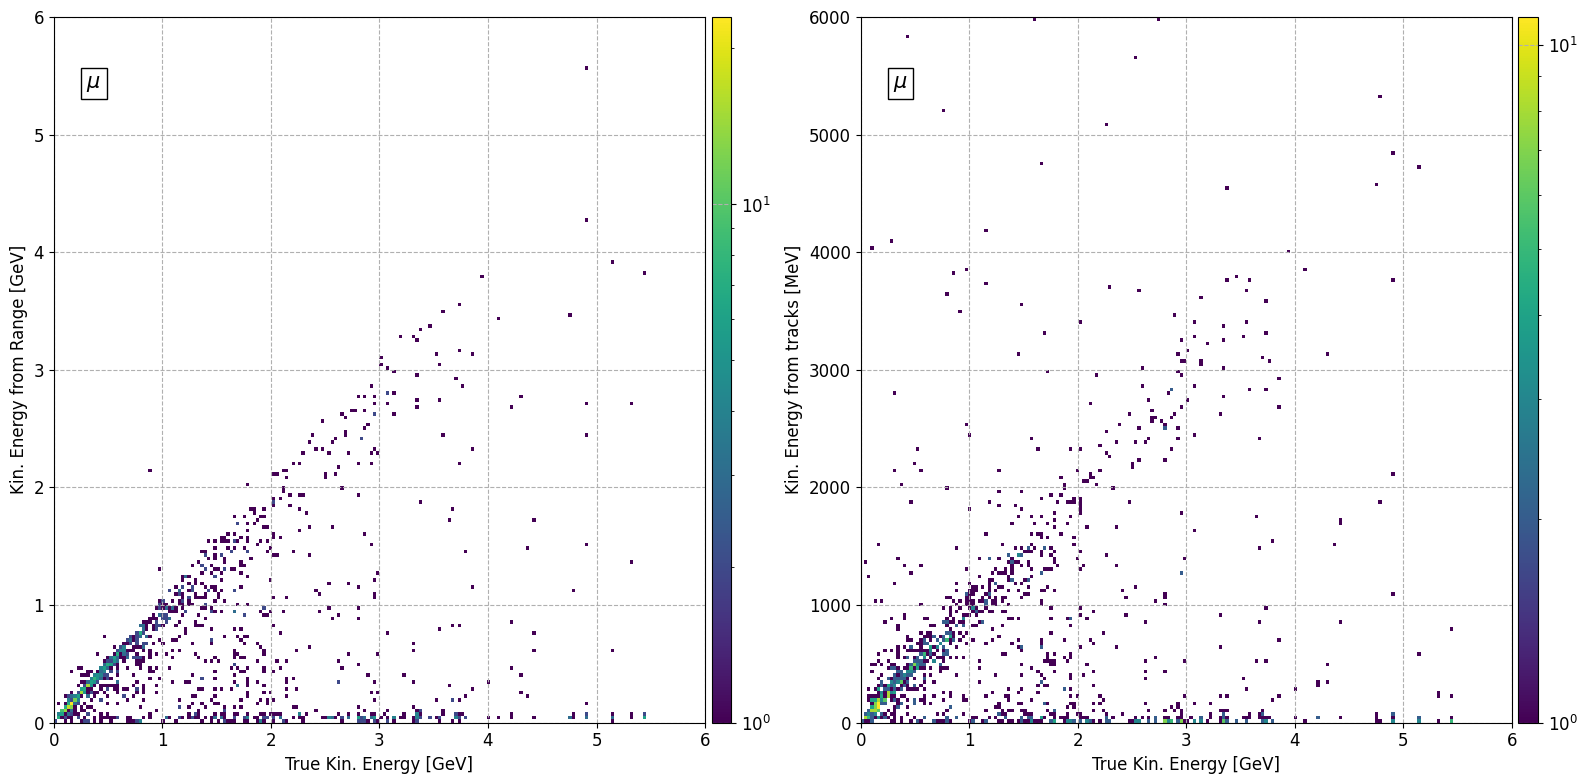

In [56]:


fig, axis = plt.subplots(1,2,figsize=(16,8))
ax = axis[0]
h = ax.hist2d(mu_true_ke, mu_ke_from_p, bins=[200,200], range=[[0,6],[0,6]], norm="log")
ax.text(0.05,0.9,r'$\mu$',bbox={'facecolor': 'white'}, fontsize=15, transform=ax.transAxes)
ax.set_xlabel(r'True Kin. Energy [GeV]')
ax.set_ylabel(r'Kin. Energy from Range [GeV]')
cax = ax.inset_axes([1.01, 0, 0.03, 1])
fig.colorbar(h[3],ax=ax, cax=cax)

ax = axis[1]
h = ax.hist2d(mu_true_ke, mu_ke, bins=[200,200], range=[[0,6],[0,6000]], norm="log")
ax.text(0.05,0.9,r'$\mu$',bbox={'facecolor': 'white'}, fontsize=15, transform=ax.transAxes)
ax.set_xlabel(r'True Kin. Energy [GeV]')
ax.set_ylabel(r'Kin. Energy from tracks [MeV]')
cax = ax.inset_axes([1.01, 0, 0.03, 1])
fig.colorbar(h[3],ax=ax, cax=cax)

fig.tight_layout()
plt.show()

        
        
        


In [52]:
p_ke = []
p_p = []
p_ke_from_p = []
p_true_ke = []
ana.data = data
for ana.ev in data:
    if not ana.ev["ntracks_pandoraTrack"]:
        continue
    # ana.make_tree()
    ana.create_pdg_ids()
    for i in range(ana.ev["ntracks_pandoraTrack"]):
        track_to_pdg_id = ana.ev["trkidtruth_pandoraTrack"][i]
        track_to_pdg_id = list(set(track_to_pdg_id[track_to_pdg_id != -1]))
        # if len(track_to_pdg_id) > 1:
        #     print("~"*30)
        #     print(f"STOO{'O'*20}P")
        #     for id in track_to_pdg_id:
        #         print(f'{id}, pdg = {ana.get_pdg_name(ana.pdgs[id][0])}')
        #     print("~"*30)
        track_to_pdg_id = track_to_pdg_id[0]
        pdg_idx = ana.pdgs[track_to_pdg_id][1]
        pdg_code = ana.ev["pdg_geant"][pdg_idx]
        if abs(pdg_code) != 2212:
            continue
        pdg_mass = pt.Particle.from_pdgid(pdg_code).mass

        track_ke = ana.ev["trkke_pandoraTrack"][i]
        track_ke = track_ke[track_ke > 0]
        track_ke = track_ke[track_ke < 1e5]
        if len(track_ke)<1:
            continue
        track_ke = sum(track_ke)/len(track_ke)
        # track_ke = np.sqrt(track_ke*(track_ke+2*pdg_mass))
        track_mom = ana.ev["trkmomrange_pandoraTrack"][i]
        track_ke_from_range = np.sqrt(track_mom**2 + (pdg_mass/1000)**2) - pdg_mass/1000
        p_ke.append(track_ke)
        p_p.append(track_mom)
        p_ke_from_p.append(track_ke_from_range)
        p_true_ke.append(ana.ev["StartE_drifted_geant"][pdg_idx] - ana.ev["EndE_drifted_geant"][pdg_idx])

        # print(f'{ana.get_pdg_name(ana.ev["pdg_geant"][pdg_idx])}, id:{track_to_pdg_id} En = {track_ke}, P = {track_mom}, K_range = {track_ke_from_range}')

    # print("")

        
        
        


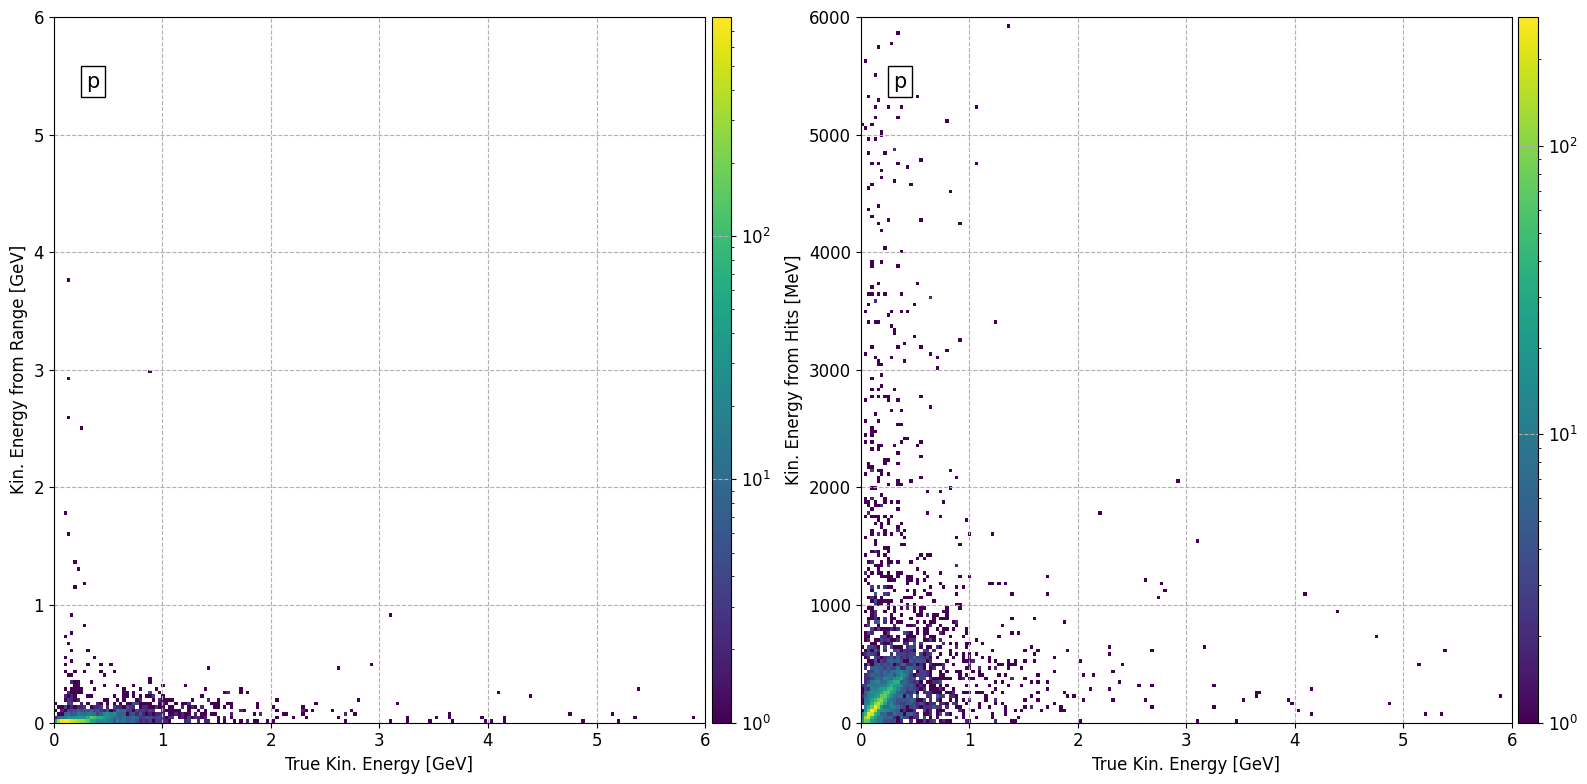

In [53]:


fig, axis = plt.subplots(1,2,figsize=(16,8))
ax = axis[0]
h = ax.hist2d(p_true_ke, p_ke_from_p, bins=[200,200], range=[[0,6],[0,6]], norm="log")
ax.text(0.05,0.9,'p',bbox={'facecolor': 'white'}, fontsize=15, transform=ax.transAxes)
ax.set_xlabel(r'True Kin. Energy [GeV]')
ax.set_ylabel(r'Kin. Energy from Range [GeV]')
cax = ax.inset_axes([1.01, 0, 0.03, 1])
fig.colorbar(h[3],ax=ax, cax=cax)

ax = axis[1]
h = ax.hist2d(p_true_ke, p_ke, bins=[200,200], range=[[0,6],[0,6000]], norm="log")
ax.text(0.05,0.9,'p',bbox={'facecolor': 'white'}, fontsize=15, transform=ax.transAxes)
ax.set_xlabel(r'True Kin. Energy [GeV]')
ax.set_ylabel(r'Kin. Energy from Hits [MeV]')
cax = ax.inset_axes([1.01, 0, 0.03, 1])
fig.colorbar(h[3],ax=ax, cax=cax)

fig.tight_layout()
plt.show()

        
        
        


In [155]:
mask_scat = data["pdg_geant"][:,0]
mask_scat  = np.isin(mask_scat, [14,-14])

mask = data["nuPDG_truth"][:,0]
mask = np.isin(mask, [14,-14])
mask2 = data["ntracks_pandoraTrack"] > 0
# np.count_nonzero(mask)
# mask2 = ak.any(mask2 > 0, axis=-1)

mask = mask_scat
data_nu = data[mask]

data_nu_and_track = data[mask & mask2]
data_nu_and_no_track = data[mask & np.bitwise_not(mask2)]
for ev in data_nu[0:20]:
    ana.ev = ev
    ana.make_tree()
    ana.create_pdg_ids()

    ana.print_pdg_tree(2,En="Eng_geant",tetha="theta_geant")

0:nu(mu)~ 1.0000 
├── 1:nu(mu)~ En: 3.1411 tetha: 2.5019 
├── 2:pi0 En: 0.7777 tetha: 1.9769 
├── 3:p En: 5.7017 tetha: 2.4369 
├── 4:p En: 1.3461 tetha: 1.8634 
├── 5:p En: 1.3121 tetha: 2.2999 
├── 6:n En: 1.0797 tetha: 1.7067 
├── 7:pi- En: 1.9976 tetha: 2.3336 
├── 8:pi+ En: 2.3084 tetha: 2.5585 
├── 9:pi- En: 1.1928 tetha: 2.7528 
├── 10:pi0 En: 1.7567 tetha: 2.5248 
├── 11:p En: 1.0746 tetha: 2.4019 
├── 12:p En: 1.0014 tetha: 1.1337 
├── 13:p En: 1.1094 tetha: 1.2765 
├── 14:n En: 1.0419 tetha: 2.6624 
└── 15:pi+ En: 0.2323 tetha: 1.2149 
0:nu(mu)~ 1.0000 
├── 1:nu(mu)~ En: 5.1102 tetha: 1.4620 
└── 2:n En: 1.0134 tetha: 2.4052 
0:nu(mu) 1.0000 
├── 1:nu(mu) En: 1.6157 tetha: 1.5400 
├── 2:gamma En: 0.5865 tetha: 1.9306 
├── 3:gamma En: 2.0743 tetha: 1.9555 
├── 4:pi- En: 5.9637 tetha: 1.8847 
├── 5:pi+ En: 0.7837 tetha: 1.7243 
├── 6:n En: 1.2743 tetha: 1.8649 
├── 7:pi- En: 1.0748 tetha: 1.5148 
├── 8:pi+ En: 0.3303 tetha: 2.1207 
├── 9:pi0 En: 3.5709 tetha: 1.9086 
├── 10:p E

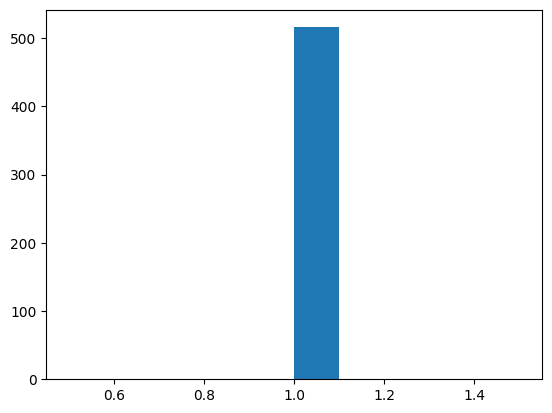

In [157]:
plt.hist(ak.flatten(data_nu["ccnc_truth"]))
plt.show()

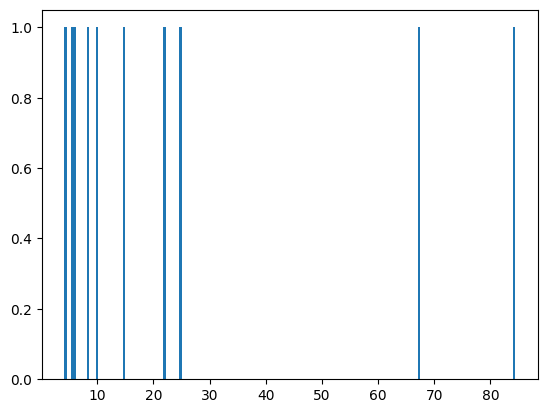

In [11]:
nevents = len(ak.flatten(data_nu["nu_dcosx_truth"]))
nu_theta_from_versor = np.zeros(nevents)
nu_phi_from_versor = np.zeros(nevents)
scattered_angle = np.zeros(nevents)
aux = 0

innu = np.zeros(3)
outnu = np.zeros(3)
for ev in data_nu:
    x,y, z = ev["nu_dcosx_truth"][0], ev["nu_dcosy_truth"][0], ev["nu_dcosz_truth"][0]
    theta, phi = get_theta_phi(x,y,z)
    nu_theta_from_versor[aux] = theta
    nu_phi_from_versor[aux] = phi
    innu = [x,y,z]
    costheta = np.cos(ev["theta_geant"][0])
    sintheta = np.sin(ev["theta_geant"][0])
    cosphi = np.cos(ev["phi_geant"][0])
    sinphi = np.sin(ev["phi_geant"][0])
    xout = cosphi*sintheta
    yout = sinphi*sintheta
    zout = costheta
    outnu = [xout, yout, zout]
    scattered_angle[aux]  = np.arccos(np.dot(innu,outnu))
    aux+=1

# nu_theta_from_versor
plt.hist(scattered_angle*180/np.pi,bins=200)
plt.show()

In [7]:
theta_nu = data_nu["theta_geant"][:,0]
phi_nu = data_nu["phi_geant"][:,0]
data_nu["pdg_geant"]

<Array [[-14, 111, 2212, ..., 1000180400, 22, 22], ...] type='10 * var * int32'>

NameError: name 'theta_nu' is not defined

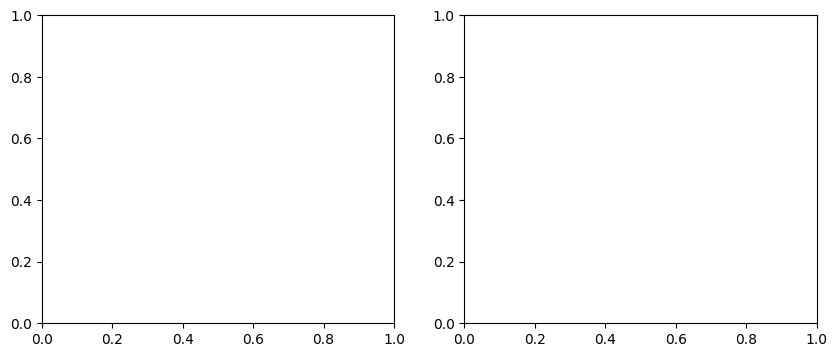

In [204]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist((theta_nu - nu_theta_from_versor),bins=200)
axes[1].hist(phi_nu - nu_phi_from_versor,bins=200)
plt.show()

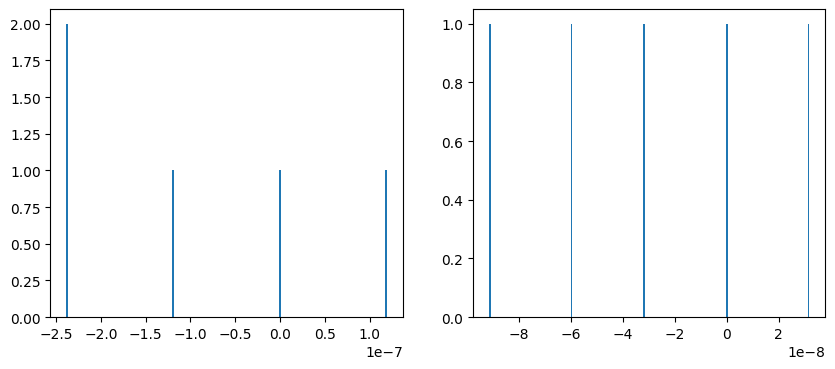

In [ ]:
theta_trk = data_nu_and_track["trktheta_pandoraTrack"][:,0]
phi_trk = data_nu_and_track["trkphi_pandoraTrack"][:,0]

trk_theta_from_versor = np.zeros(len(ak.flatten(data_nu_and_track["nu_dcosx_truth"])))
trk_phi_from_versor = np.zeros(len(ak.flatten(data_nu_and_track["nu_dcosx_truth"])))
aux = 0
for ev in data_nu_and_track:
    x,y, z = ev["trkstartdcosx_pandoraTrack"][0], ev["trkstartdcosy_pandoraTrack"][0], ev["trkstartdcosz_pandoraTrack"][0]
    theta, phi = get_theta_phi(x,y,z)
    trk_theta_from_versor[aux] = theta
    trk_phi_from_versor[aux] = phi
    aux+=1

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist((theta_trk - trk_theta_from_versor),bins=200)
axes[1].hist(phi_trk - trk_phi_from_versor,bins=200)
plt.show()

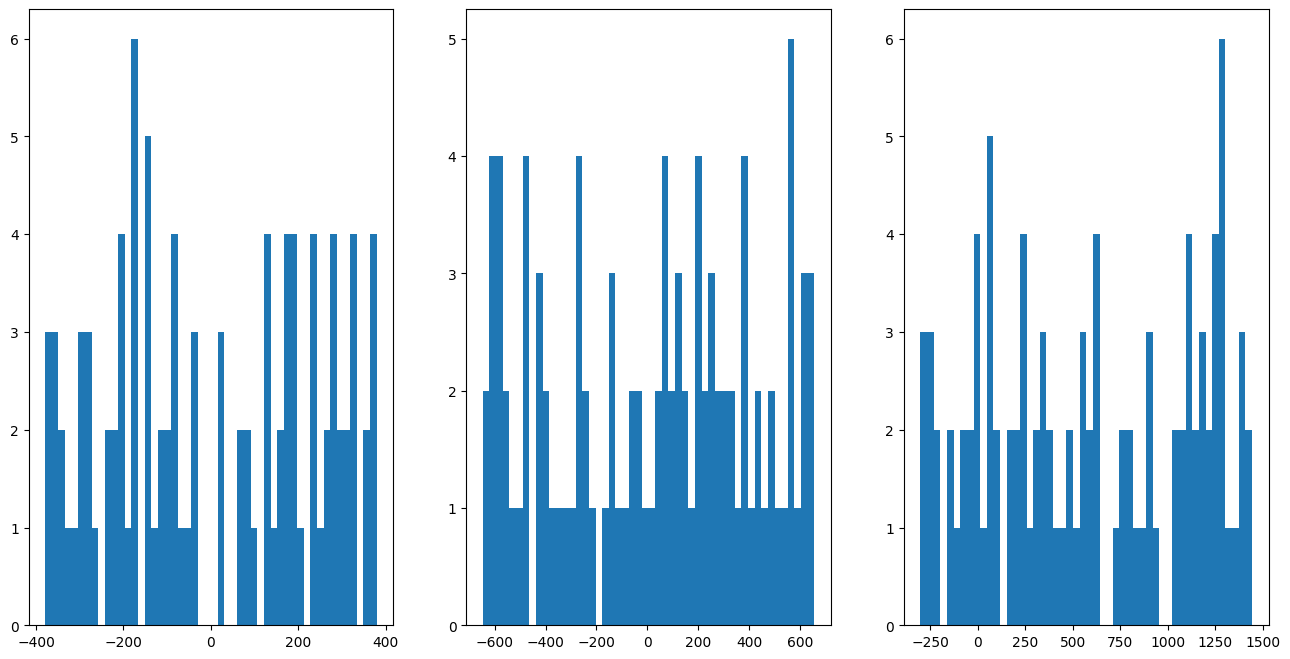

In [9]:

figs, axis = plt.subplots(1,3,figsize=(16,8))
coordinates = ["x","y", "z"]
for coord, ax in zip(coordinates, axis):
    ax.hist(ak.flatten(data[f"nuvtx{coord}_truth"],axis=-1),bins=50)



In [10]:
mask = [np.any(state) for state in data["pfp_pdgCode"]]
data_pfp = data[mask]
data_pfp["pfp_pdgCode"][:,-1]

<Array [14, 12, 14, 14, 12, 12, ..., 14, 12, 14, 12, 12, 12] type='84 * int32'>

In [25]:
for ev in data[0:20]:
    # take only the primaries
    ana.ev = ev
    subset = ev["pdg_geant"][ev["Mother_geant"] == 0]
    # mu here also have the information of which node will correspond to the muon
    mu = np.isin(subset, [13, -13])
    if np.any(mu):
        ana.make_tree()
        ana.create_pdg_ids()
        mu_candidates = np.where(mu == True) # gives me the index of the muon
        for mu_nod in mu_candidates:
            print(f'event: {ev["event"]}, run: {ev["run"]}')
            ana.print_pdg_tree(2,node=mu_nod[0]+1,en="Eng_geant", endE="EndE_geant")
        # ana.print_my_tree(3,En="Eng_geant", P="P_geant")
        # break

# ana.print_pdg_tree(2,En="Eng_geant", P="P_geant",node=1)
# np.where(mu==True)

event: 1, run: 20000063
1:mu- en: 3.6886 endE: 3.5269 
├── 4498:gamma en: 0.0001 endE: -99999.0000 
├── 4499:gamma en: 0.0001 endE: -99999.0000 
├── 4500:gamma en: 0.0003 endE: -99999.0000 
├── 4501:gamma en: 0.0012 endE: -99999.0000 
├── 4502:nu(mu) en: 0.0244 endE: -99999.0000 
├── 4503:p en: 0.9614 endE: -99999.0000 
├── 4504:n en: 0.9553 endE: -99999.0000 
├── 4505:n en: 0.9417 endE: -99999.0000 
├── 4506:gamma en: 0.0015 endE: -99999.0000 
├── 4507:gamma en: 0.0008 endE: -99999.0000 
├── 4508:n en: 0.9401 endE: -99999.0000 
└── 4509:Cr52 en: 48.3702 endE: -99999.0000 
event: 3, run: 20000063
1:mu+ en: 0.4247 endE: 0.4247 
├── 695:nu(mu)~ en: 0.0501 endE: 0.0501 
├── 696:nu(e) en: 0.0181 endE: 0.0181 
└── 697:e+ en: 0.0370 endE: 0.0370 
event: 4, run: 20000063
1:mu- en: 0.4842 endE: 0.4185 
├── 328:gamma en: 0.0008 endE: -99999.0000 
├── 329:nu(mu) en: 0.0549 endE: 0.0549 
├── 330:n en: 0.9612 endE: -99999.0000 
├── 331:gamma en: 0.0043 endE: -99999.0000 
├── 332:gamma en: 0.0016 e

In [12]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
subrun               | int32_t                  | AsDtype('>i4')
event                | int32_t                  | AsDtype('>i4')
evttime              | double                   | AsDtype('>f8')
beamtime             | double                   | AsDtype('>f8')
pot                  | double                   | AsDtype('>f8')
isdata               | int8_t                   | AsDtype('int8')
taulife              | double                   | AsDtype('>f8')
triggernumber        | uint32_t                 | AsDtype('>u4')
triggertime          | double                   | AsDtype('>f8')
beamgatetime         | double                   | AsDtype('>f8')
triggerbits          | uint32_t                 | AsDtype('>u4')
potbnb               | double                   | AsDtype

In [13]:
pt.Particle.from_pdgid(1000020040)


<Particle: name="He4", pdgid=1000020040, mass=3728.4013213 MeV>